<a href="https://colab.research.google.com/github/mateocapon/simulacion_tp1/blob/main/Ejercicio%208.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import scipy
import matplotlib.pyplot as plt
import numpy as np
import random
import seaborn as sns

import pandas as pd

## Generacion del tablero

In [2]:
def generarTablero( cantCeldas, habitantes ):

    """
    Genero un tablero de cantCeldas x cantCeldas    
    """

    tableroInicial = []
    tableroConLetras = []

    for i in range(0,cantCeldas):
        linea = np.random.rand(cantCeldas)
        tableroInicial.append(linea)
        tableroConLetras.append([0 for x in range(0,cantCeldas)])

    print("Tablero generado de : " + str(len(tableroInicial)) + " x " + str(len(tableroInicial[0])))

    return inicializarTablero( tableroInicial, tableroConLetras, habitantes )



def inicializarTablero(t, tablero, habitantes):
    """
    Inicializo un tablero de cantCeldas x cantCeldas con valores entre [0,1]
    
    Devuelve un array de cantCeldas x cantCeldas con la representacion de personas [X,A,B,C]
    """

    pHabitantes = habitantes/(len(t)*len(t))

    pContagiados = 0.03*pHabitantes

    habitantesGenerados = 0
    habitantesGeneradosContagiados = 0

    for i in range(0,len(tablero)):

        for j in range(0,len(tablero[i])):

            x = t[i][j]

            if x <= pContagiados:
                tablero[i][j] = "X0"
                habitantesGeneradosContagiados += 1

            elif x <= pHabitantes:
                y = np.random.rand(1)
                habitantesGenerados += 1

                if y <= 0.7:
                    tablero[i][j] = "A"
                if y <= 0.9:
                    tablero[i][j] = "B"
                else:
                    tablero[i][j] = "C"
                
            else:
                tablero[i][j] = "-"

    print("Cantidad de celdas: " + str(cant_celdas*cant_celdas))
    print("Habitantes generados: " + str(habitantesGenerados))
    print("Habitantes generados contagiados: " + str(habitantesGeneradosContagiados)) 
    print("Porcentaje inicia de poblacion contagiada: " + str(habitantesGeneradosContagiados/habitantesGenerados) )
    print("--------------------------------")
    
    return tablero

## Movimiento por iteraciones

In [3]:
def randomWalk(r):
    """Dado un numero random entre [0,1] devuelvo una tupla con valores"""
    if r < 0.25:
        return (0,1)
    if r < 0.5:
        return (1,0)
    if r < 0.75:
        return (-1,0)
    else:
        return (0,-1)


def moverPersonas( tablero, seMueveB, seMueveC, medidasGovierno, recuperacion, pRecuperacion ):
    """Recorro el tablero moviendo a las personas de manera random y buscando las zonas de contagio"""    
    for i in range(0,len(tablero)):
        for j in range(0,len(tablero[i])):

            r = np.random.random()

            if tablero[i][j] == "A":
                movimiento = randomWalk(r)
                if verificarMovimiento( tablero, i, j, movimiento ):
                    reemplazar(tablero, i, j, movimiento, "A")

            elif seMueveB and tablero[i][j] == "B":
                movimiento = randomWalk(r)
                if verificarMovimiento( tablero, i, j, movimiento ):
                    reemplazar(tablero, i, j, movimiento, "B")

            elif seMueveC and tablero[i][j] == "C":
                movimiento = randomWalk(r)
                if verificarMovimiento( tablero, i, j, movimiento ):
                    reemplazar(tablero, i, j, movimiento, "C")

            elif tablero[i][j][0] == 'X':
                contagiarPersonas( tablero, i, j, medidasGovierno )
                instante = int( tablero[i][j][1] ) + 1

                if instante >= recuperacion:                    
                    if r < pRecuperacion:
                        darDeAlta( tablero, i, j )
                else:
                    tablero[i][j] = "X"+ str(instante)

pInmunizar = 0.3

def darDeAlta( t, i, j ):
    r = np.random.random()

    if r < pInmunizar:
        t[i][j] = "R"
    else:
        t[i][j] = np.random.choice(["A","B","C"],p=[0.7, 0.2, 0.1])
    

def verificarMovimiento( t, i, j, movimiento ):
    """Checkeo que no haya nadie en la pos a mover"""
    x = i + movimiento[0]
    y = j + movimiento[1]

    if x < 0 or x >= 250 or y < 0 or y >= 250:
        return False

    if t[x][y] == "-" :
        return True

    return False


def reemplazar( t, i, j, movimiento, caracter ):
    """Reemplazo a un lugar vacio por una persona"""
    x = i + movimiento[0]
    y = j + movimiento[1]
    t[i][j] = "-"
    t[x][y] = caracter




## Contagios

In [4]:
def contagiarPersonas( t, x, y, medidasGovierno ):
    """ Si hay alguien contagiado busco las 5 casillas al rededor y veo si contagio a esa persona """
    for i in range(-5,6):
        
        if (x+i < 0 or x+i >= 250):
            continue

        for j in range(-5,6):
         
            if (i == 0 and j == 0) or y+j < 0 or y+j >=250:
                continue
         
            if t[x+i][y+j] in ["A","B","C"]:
                r = np.random.random()
                if r < (0.65 - medidasGovierno):
                    contagiar( t, x+i, y+j )



def contagiar( tablero, x, y ):
    tablero[x][y] = "X0"


## Vemos como quedaria el mapa 

Donde:

Xi - Contagiados durante i periodos de tiempo

R - Persona recuperada

A - Habitante de tipo A

B - Habitante de tipo B

C - Habitante de tipo C



In [5]:
metros = 100
tamaño_celda = 0.4

cant_celdas = int( metros/tamaño_celda )

habitantes = 10000

mapa = generarTablero( cant_celdas, habitantes )

Tablero generado de : 250 x 250
Cantidad de celdas: 62500
Habitantes generados: 9701
Habitantes generados contagiados: 285
Porcentaje inicia de poblacion contagiada: 0.029378414596433356
--------------------------------


In [6]:
df = pd.DataFrame(data=mapa)

df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249
0,-,-,-,-,-,-,-,-,C,C,-,-,-,-,-,B,C,-,C,C,B,-,-,-,-,X0,-,-,-,B,-,-,-,-,-,-,B,-,-,-,...,-,B,-,-,-,-,-,-,B,-,-,B,-,-,-,-,-,-,-,B,-,-,-,B,-,B,-,-,B,B,-,-,-,-,-,B,-,-,-,-
1,-,-,B,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,B,-,-,B,-,B,-,-,-,-,...,-,-,B,-,B,B,B,B,-,-,-,-,-,-,-,B,-,-,-,-,B,-,-,-,-,-,-,-,-,-,-,-,-,B,B,-,B,B,B,-
2,-,-,-,-,-,-,-,-,B,B,B,B,-,-,B,-,-,-,-,B,-,-,-,-,B,-,-,-,C,-,-,-,-,B,-,-,-,B,-,-,...,-,-,-,-,-,-,-,B,-,B,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,C,-,-,-,-,-,-,-,-,B,-
3,-,X0,-,B,-,-,-,-,C,-,-,B,-,B,B,-,C,-,-,-,-,-,-,-,B,-,B,B,-,-,-,-,-,-,B,B,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-,B,-,-,-,-,-,-,B,C,-,-,-,-,-,-,-,-,-,B,-,-,-,-,-,-,B,B,C,-,-
4,-,-,-,-,-,B,-,-,-,-,B,B,-,B,-,-,-,-,-,-,-,-,-,-,-,B,-,B,-,-,-,-,B,-,-,-,B,-,-,-,...,-,-,-,X0,-,-,-,-,-,-,-,B,-,-,C,-,B,X0,-,B,-,-,B,-,-,-,-,-,-,-,-,-,-,-,-,-,C,-,-,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,B,-,-,-,-,-,-,-,-,-,-,-,-,B,-,-,-,-,-,-,B,-,-,C,-,-,-,-,-,C,-,-,-,-,-,-,-,-,-,-,...,-,B,-,-,-,-,-,-,-,C,-,-,-,-,-,-,-,B,C,-,-,-,-,-,B,-,-,-,-,-,-,-,-,-,B,-,-,B,-,-
246,B,-,-,-,B,-,C,-,-,-,-,-,-,-,-,-,-,-,-,B,-,-,-,-,B,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,B,-,-,-,-,-,B,-,B,B,-,-,-,-,-,-,-,B,-,B,-,B,-,-
247,B,-,-,-,-,-,-,-,-,-,-,-,-,-,B,-,B,-,-,-,-,B,-,-,-,-,-,B,-,C,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,B,-,-,-,B,-,-,-,-,B,-,-,-,-,-,-,-,-,B,B,B,-,-,-,-,-,-,B,-,-,-,-,-,-,-
248,-,-,-,-,-,-,-,-,-,-,-,-,-,C,-,-,-,-,-,-,B,C,B,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,...,-,-,-,B,C,-,-,B,-,-,-,-,-,-,-,-,-,-,B,-,-,-,-,B,-,-,B,-,B,-,-,-,-,-,B,-,-,-,-,-


## Realizacion de conteo

In [7]:
def realizarConteo(tablero):
    habitantesSanos = 0
    habitantesContagiados = 0
    habitantesRecuperados = 0

    for i in range(0,len(tablero)):

        for j in range(0,len(tablero[i])):

            x = tablero[i][j]

            if x in ["A","B","C"]:
                habitantesSanos += 1
            elif "X" in x:
                habitantesContagiados += 1
            elif x == "R":
                habitantesRecuperados += 1
    habitantes = habitantesSanos+habitantesContagiados+habitantesRecuperados
            
    print("Habitantes: " + str(habitantes) )
    print("Habitantes sanos: " + str(habitantesSanos) )
    print("Habitantes contagiados: " + str(habitantesContagiados) )
    print("Habitantes inmunizados: " + str(habitantesRecuperados) )
    print("----------------------------")
    print("Porcentaje de poblacion sana: " + str(habitantesSanos/habitantes) )
    print("Porcentaje de poblacion contagiada: " + str(habitantesContagiados/habitantes) )
    print("Porcentaje de poblacion inmunizados: " + str(habitantesRecuperados/habitantes) )
    return ( habitantesSanos, habitantesContagiados, habitantesRecuperados, habitantesSanos+habitantesRecuperados )


## Graficos

In [8]:
def plotHeatMap(mapa):
    df = pd.DataFrame( data=mapa )

    df = df.replace(["A","B","C"],"H")

    values = []

    for i in range(0,15):
        values.append("X"+str(i))

    df = df.replace(values,"X")

    plt.figure(figsize=(20, 10))

    values = sorted(pd.unique(df.values.ravel()))

    value_to_int = {j:i for i,j in enumerate(values)}

    n = len(pd.unique(df.replace(value_to_int).values.ravel()))     

    # discrete colormap (n samples from a given cmap)
    if "R" in values:
        cmap = sns.color_palette(("black","lime","blue","red"), n) 
    else:
        cmap = sns.color_palette(("black","lime","red"), n)
        
    ax = sns.heatmap(df.replace(value_to_int), cmap=cmap) 

    # modify colorbar:
    colorbar = ax.collections[0].colorbar 
    r = colorbar.vmax - colorbar.vmin 
    colorbar.set_ticks( [colorbar.vmin + r / n * (0.5 + i) for i in range(n)] )
    colorbar.set_ticklabels( values )                                          
    plt.show()

In [34]:
def plotResults(list, iters):
    sns.set_theme()
    plt.figure(figsize=(15, 8))

    df2 = pd.DataFrame(results)

    df2.columns = ["Habitantes sanos","Habitantes contagiados","Habitantes inmunizados", "Habitantes sin virus"]

    ax = sns.lineplot(data = df2)
    
    ax.set_xlim(0, iters)

    plt.show()

## Simulacion

Con tiempo = 5000 tarda en ejecutarse 4 minutos.

Tablero generado de : 250 x 250
Cantidad de celdas: 62500
Habitantes generados: 4849
Habitantes generados contagiados: 147
Porcentaje inicia de poblacion contagiada: 0.030315528975046403
--------------------------------


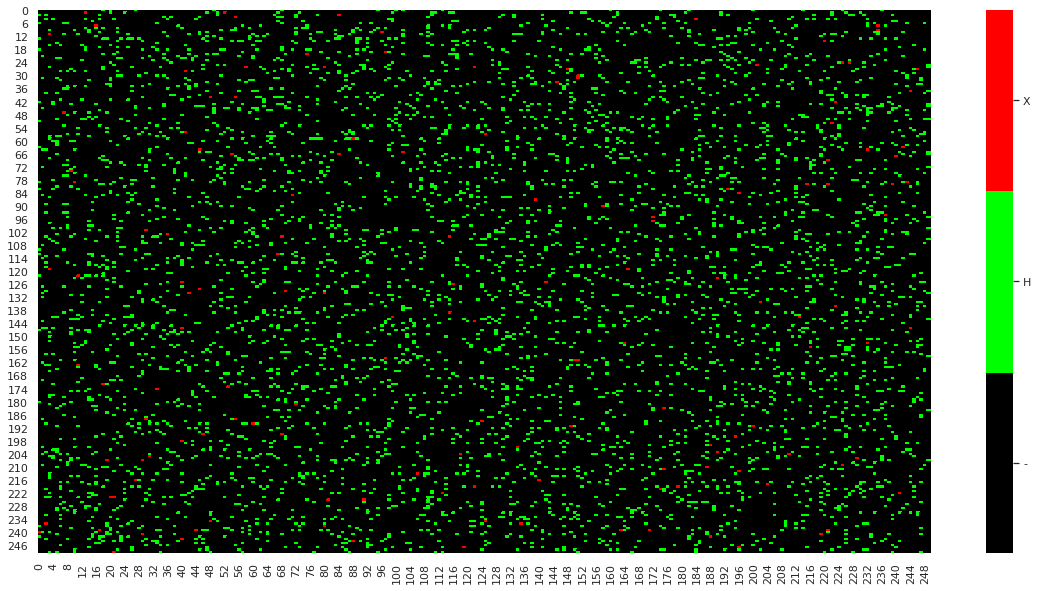

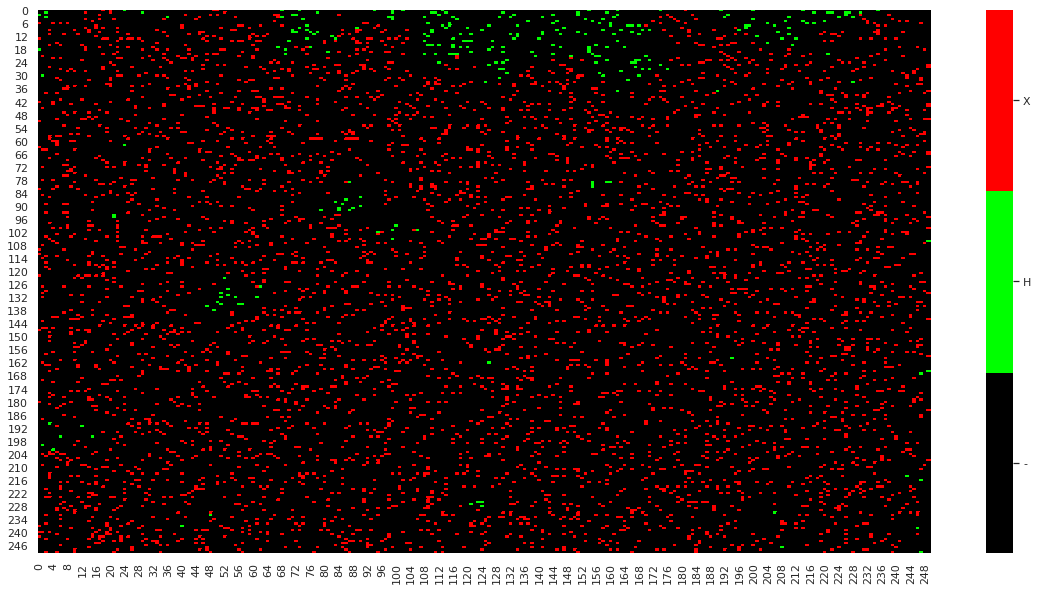

Habitantes: 4996
Habitantes sanos: 277
Habitantes contagiados: 4719
Habitantes inmunizados: 0
----------------------------
Porcentaje de poblacion sana: 0.05544435548438751
Porcentaje de poblacion contagiada: 0.9445556445156125
Porcentaje de poblacion inmunizados: 0.0


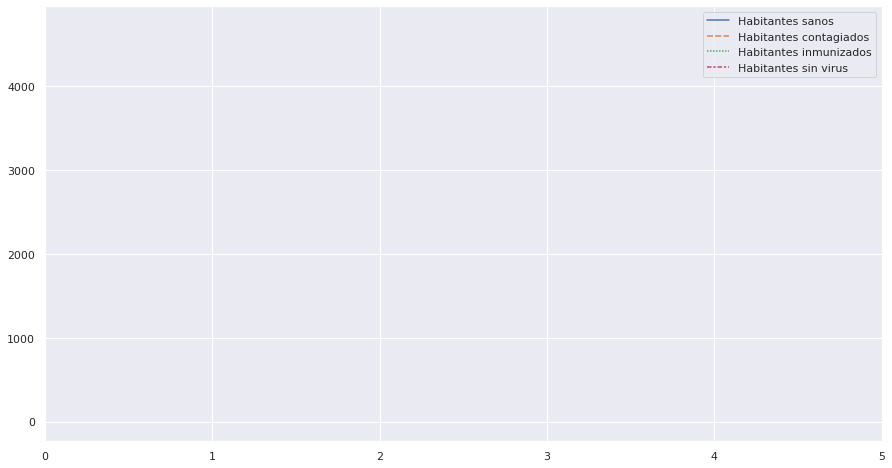

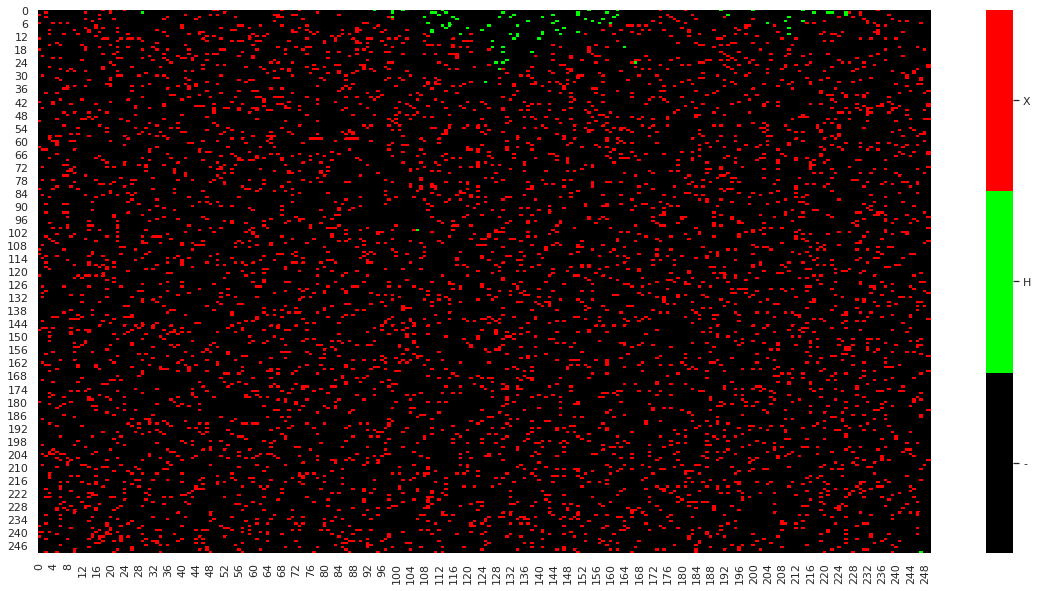

Habitantes: 4996
Habitantes sanos: 87
Habitantes contagiados: 4909
Habitantes inmunizados: 0
----------------------------
Porcentaje de poblacion sana: 0.017413931144915934
Porcentaje de poblacion contagiada: 0.982586068855084
Porcentaje de poblacion inmunizados: 0.0


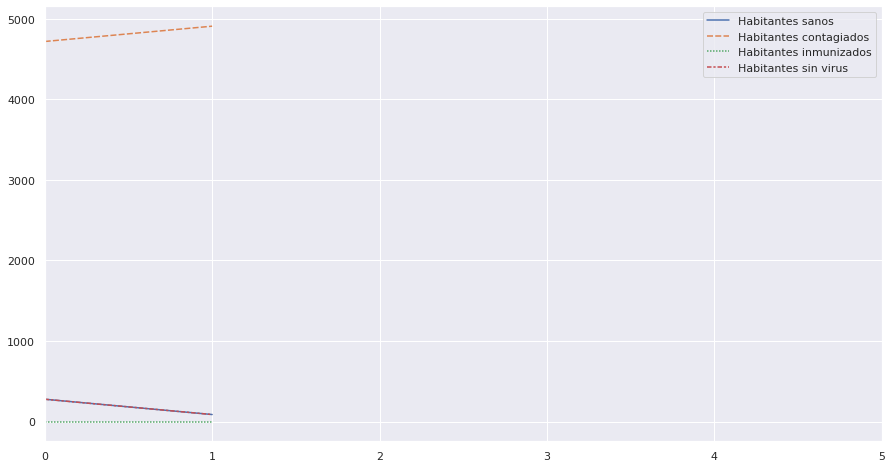

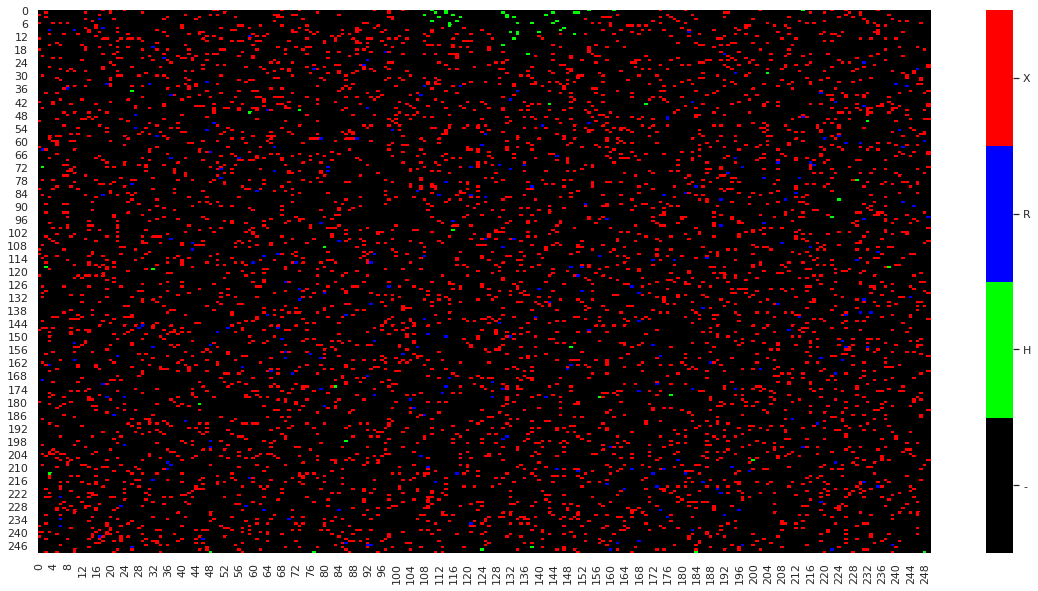

Habitantes: 4996
Habitantes sanos: 67
Habitantes contagiados: 4649
Habitantes inmunizados: 280
----------------------------
Porcentaje de poblacion sana: 0.013410728582866294
Porcentaje de poblacion contagiada: 0.9305444355484388
Porcentaje de poblacion inmunizados: 0.05604483586869496


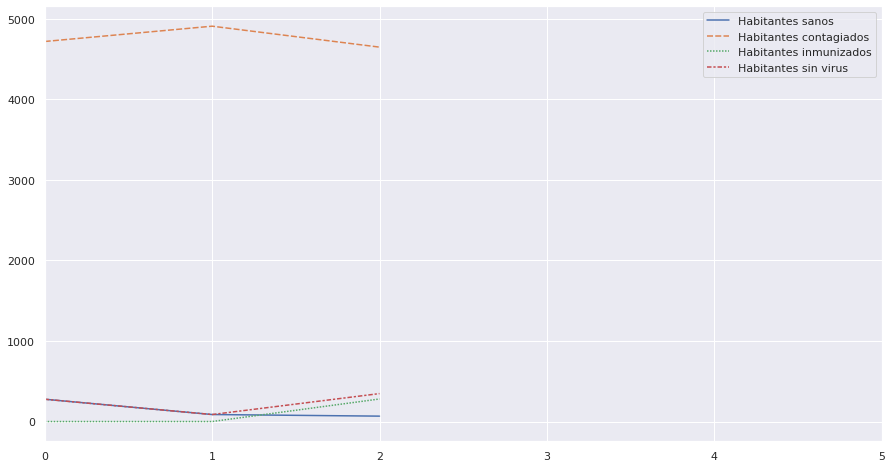

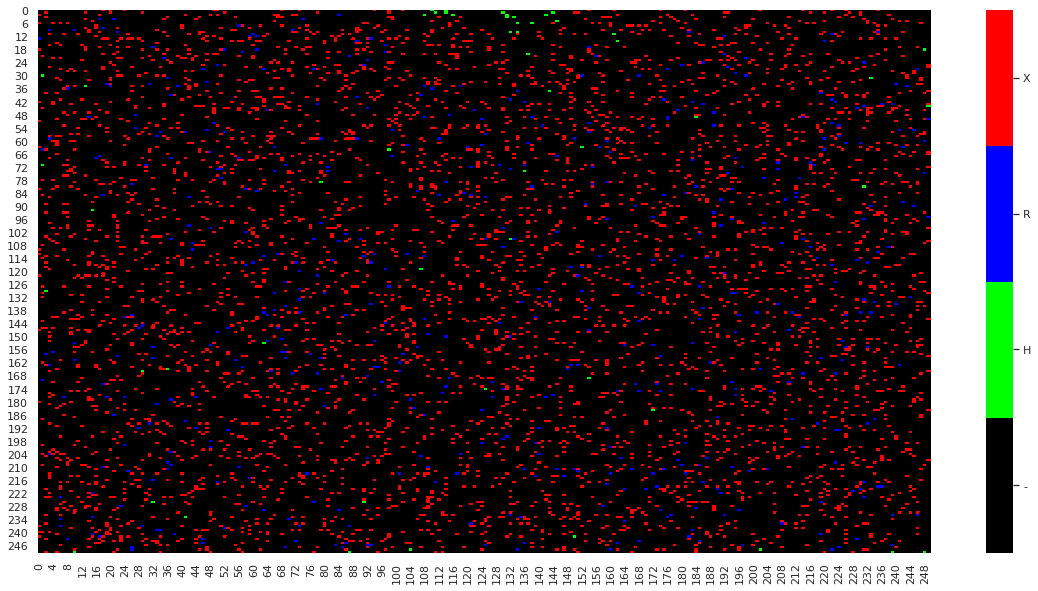

Habitantes: 4996
Habitantes sanos: 53
Habitantes contagiados: 4417
Habitantes inmunizados: 526
----------------------------
Porcentaje de poblacion sana: 0.010608486789431545
Porcentaje de poblacion contagiada: 0.8841072858286629
Porcentaje de poblacion inmunizados: 0.10528422738190553


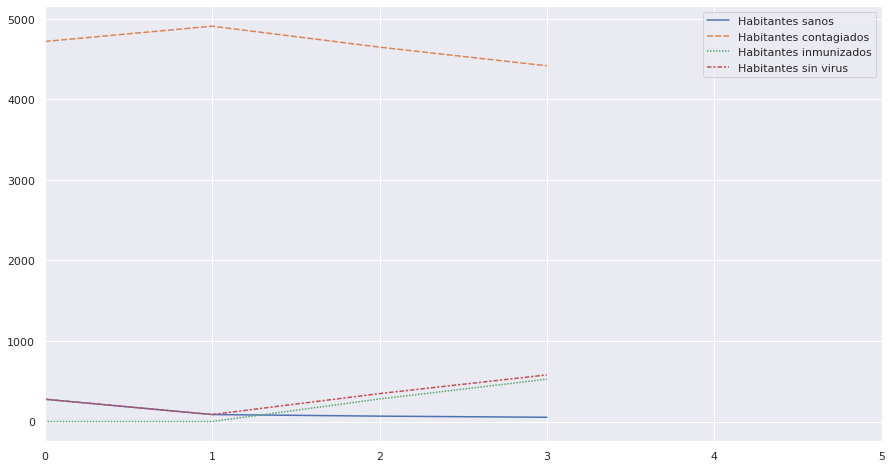

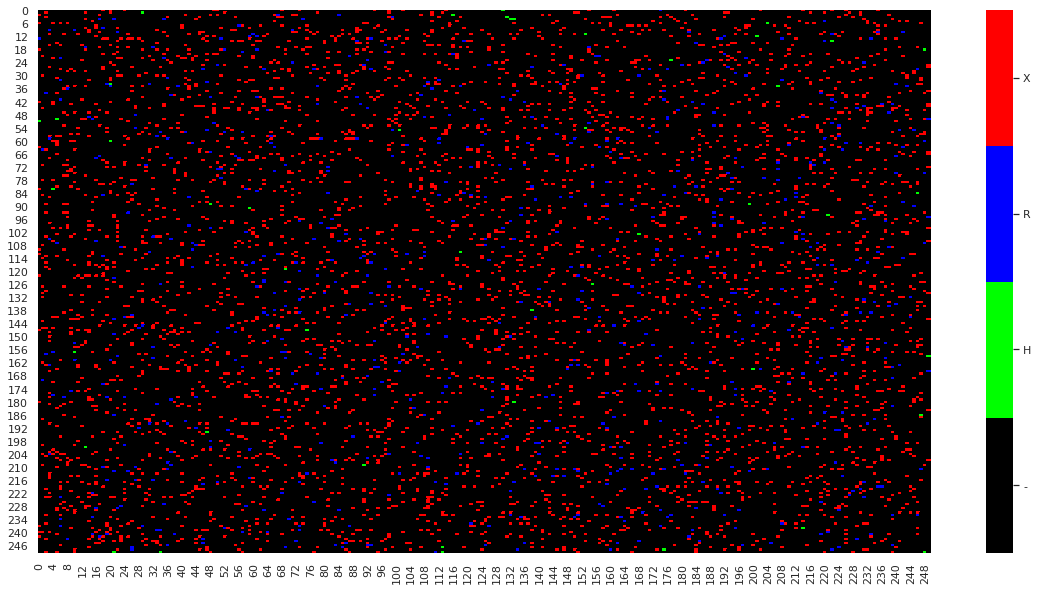

Habitantes: 4996
Habitantes sanos: 46
Habitantes contagiados: 4218
Habitantes inmunizados: 732
----------------------------
Porcentaje de poblacion sana: 0.009207365892714172
Porcentaje de poblacion contagiada: 0.844275420336269
Porcentaje de poblacion inmunizados: 0.1465172137710168


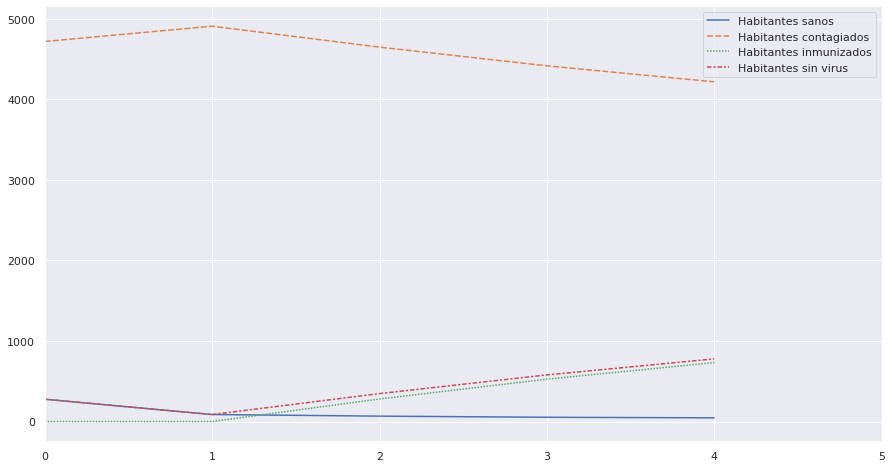

In [27]:
metros = 100
tamaño_celda = 0.4
cant_celdas = int( metros/tamaño_celda )

habitantes = 5000
mapa = generarTablero( cant_celdas, habitantes )

maxTime = 5
T = 25

intantesParaRecuperacion = 3
pRecuperacion = 0.2

plotHeatMap(mapa)
results = []

for iter in range(0, maxTime):
    
    seMueveB = True if iter%2 == 0 else False
    seMueveC = True if iter%4 == 0 else False

    medidasGovierno = 0.15 if iter > T else 0

    moverPersonas( mapa, seMueveB, seMueveC, medidasGovierno, intantesParaRecuperacion, pRecuperacion )
    
    plotHeatMap( mapa )
    lista = realizarConteo(mapa)
    results.append( lista )
    plotResults( results, maxTime )

    if lista[1] == 0:
        print("No hay mas gente contagiada, intervalos de tiempo recorridos: " + str(iter) )
        break


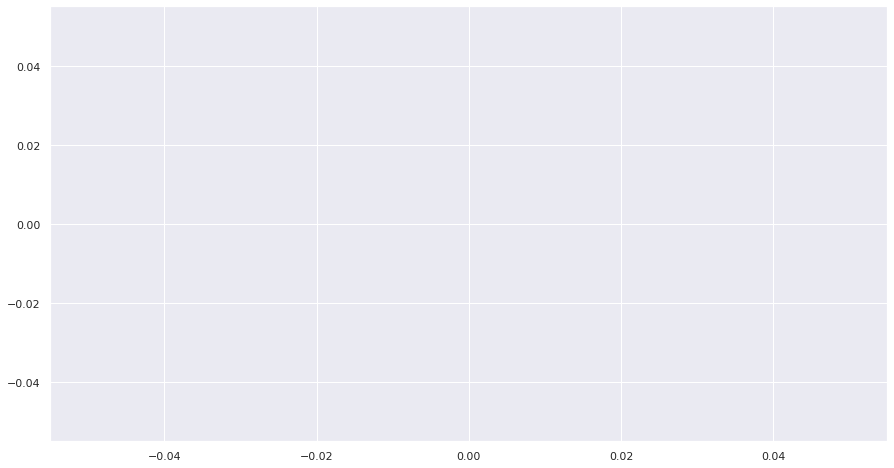

In [35]:
plotResults(results,5)